In [2]:
!pip install pytesseract
!pip install ultralytics
!pip install ftfy regex tqdm faiss-cpu


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("VisionTextAI") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

sc = spark.sparkContext


25/04/26 18:31:22 WARN Utils: Your hostname, Ks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.29.241 instead (on interface en0)
25/04/26 18:31:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 18:31:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
import os
import cv2
from pyspark.sql import Row

image_dir = "/Users/sanjay/Downloads/archive/images/flickr30k_images"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

def preprocess_image_light(path):
    try:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        save_dir = "/Users/sanjay/Downloads/resized_images"
        os.makedirs(save_dir, exist_ok=True)
        resized_path = os.path.join(save_dir, os.path.basename(path))
        cv2.imwrite(resized_path, img)
        return Row(filename=os.path.basename(path), path=resized_path)
    except:
        return None

rdd = sc.parallelize(image_paths).map(preprocess_image_light).filter(lambda x: x is not None)
df = spark.createDataFrame(rdd)
df.write.mode("overwrite").parquet("file:///Users/sanjay/Downloads/images_metadata_only")


In [7]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.to(device)

candidates = [
    "a man riding a horse", 
    "a group of people", 
    "a beach scene", 
    "a child playing"
]

def generate_caption(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(candidates).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        logits_per_image = image_features @ text_features.T
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return candidates[np.argmax(probs)]


In [8]:
from tqdm import tqdm
import faiss

clip_features = []
file_names = []

for file in tqdm(image_paths[:1000]):  # Limit first 1000 for fast testing
    try:
        img = Image.open(file).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model.encode_image(img_tensor).cpu().numpy()
        
        clip_features.append(features[0])
        file_names.append(file)
    except Exception as e:
        continue

clip_features = np.array(clip_features)

print(f"✅ Total Encoded Features: {len(clip_features)}")

faiss_index = faiss.IndexFlatIP(512)
faiss_index.add(clip_features)

def search_similar(query_img_path, k=5):
    img = Image.open(query_img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        query_feat = model.encode_image(img_tensor).cpu().numpy()
    
    D, I = faiss_index.search(query_feat, k=k)
    return [file_names[i] for i in I[0]]


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.29it/s]

✅ Total Encoded Features: 1000


In [20]:
import pytesseract
import cv2

def extract_text(image_path):
    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray)
        return text
    except Exception as e:
        print(f"❌ OCR failed for {image_path}: {e}")
        return ""


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords(captions):
    vectorizer = TfidfVectorizer(max_features=20)
    X = vectorizer.fit_transform(captions)
    return vectorizer.get_feature_names_out()


In [24]:
from ultralytics import YOLO

detector = YOLO('yolov8n.pt')  # Lightweight YOLOv8 model

def detect_objects(image_path):
    try:
        results = detector.predict(image_path, imgsz=224, conf=0.5, verbose=False)
        detected_classes = [detector.names[int(cls)] for cls in results[0].boxes.cls]
        return detected_classes
    except Exception as e:
        print(f"❌ Object Detection failed for {image_path}: {e}")
        return []


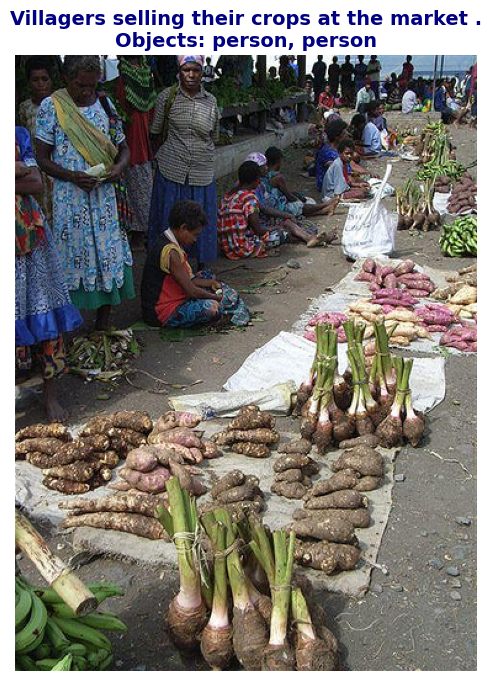


 Similar Images Found:
1. /Users/sanjay/Downloads/archive/images/flickr30k_images/3864394764.jpg
2. /Users/sanjay/Downloads/archive/images/flickr30k_images/3328852290.jpg
3. /Users/sanjay/Downloads/archive/images/flickr30k_images/4349185080.jpg
4. /Users/sanjay/Downloads/archive/images/flickr30k_images/3509224574.jpg
5. /Users/sanjay/Downloads/archive/images/flickr30k_images/3026374370.jpg

📝 OCR Extracted Text:



In [48]:
# Run all steps together

if __name__ == "__main__":
    test_img = "/Users/sanjay/Downloads/archive/images/flickr30k_images/1026792563.jpg"  # Replace with actual image path

    # Object Detection
    detected_objects = detect_objects(test_img)
    
    # Caption Generation
    caption = generate_caption(test_img)
    
    # Display Image with Caption + Detected Objects
    img = Image.open(test_img)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    title_text = caption + "\nObjects: " + ", ".join(detected_objects)
    plt.title(title_text, fontsize=14, fontweight='bold', color='navy')
    plt.show()

    # Similar Images
    print("\n Similar Images Found:")
    for idx, sim_img in enumerate(search_similar(test_img), start=1):
        print(f"{idx}. {sim_img}")

    # OCR Text Extraction
    print("\n📝 OCR Extracted Text:")
    print(extract_text(test_img))


✅ Loaded captions for 31784 images from captions.txt.


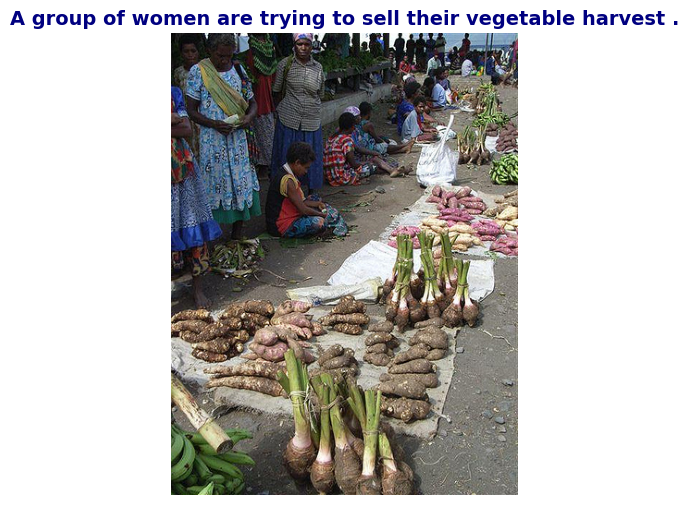

📝 Generated Caption: A group of women are trying to sell their vegetable harvest .


In [44]:
# 1. Required Imports
import os
import random
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 2. Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.to(device)

# 3. Candidate Captions for CLIP
candidates = [
    "a man riding a horse",
    "a group of people",
    "a beach scene",
    "a child playing"
]

# 4. Load Flickr30k Captions.txt (comma-separated)
captions_file = "/Users/sanjay/Downloads/archive/captions.txt"

image_captions = {}

try:
    with open(captions_file, "r") as f:
        for line in f:
            parts = line.strip().split(",", 1)
            if len(parts) == 2:
                img_id = parts[0].strip().lower()
                caption = parts[1].strip()
                
                if img_id not in image_captions:
                    image_captions[img_id] = []
                image_captions[img_id].append(caption)

    print(f"✅ Loaded captions for {len(image_captions)} images from captions.txt.")
except FileNotFoundError:
    print("⚠️ Captions.txt not found! Continuing without it.")

# 5. Define Caption Generators
def generate_caption_clip(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(candidates).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        logits_per_image = image_features @ text_features.T
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return candidates[np.argmax(probs)]

def generate_caption_from_dataset(image_path):
    filename = os.path.basename(image_path).lower()
    if filename in image_captions:
        return random.choice(image_captions[filename])
    else:
        return "No caption available."

# 6. Switchable Flag
USE_DATASET_CAPTIONS = True  # 🔵 Set True to use captions.txt, False to use CLIP

def generate_caption(image_path):
    if USE_DATASET_CAPTIONS:
        return generate_caption_from_dataset(image_path)
    else:
        return generate_caption_clip(image_path)

# 7. Example Usage - Display Image + Caption
if __name__ == "__main__":
    # ➔ Set your test image path here:
    test_img = "/Users/sanjay/Downloads/archive/images/flickr30k_images/1026792563.jpg"

    caption = generate_caption(test_img)
    
    # Load and Display Image
    img = Image.open(test_img)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=14, fontweight='bold', color='navy')
    plt.show()

    print(f"📝 Generated Caption: {caption}")


In [ ]:
!pip install ultralytics pytesseract pyttsx3
import cv2
from ultralytics import YOLO
from PIL import Image
import numpy as np
import torch
import clip
import pytesseract

# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
yolo_model = YOLO("yolov8n.pt")

# Candidate captions (you can expand this list)
candidates = ["a man", "a woman", "a car", "a dog", "a group of people", "a child", "a building", "a bike"]

# OCR
def extract_ocr(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return pytesseract.image_to_string(gray).strip()

# Caption generator
def generate_clip_caption(frame):
    image_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_input = preprocess(image_pil).unsqueeze(0).to(device)
    text_tokens = clip.tokenize(candidates).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_tokens)
        logits_per_image, _ = clip_model(image_input, text_tokens)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
    best_idx = np.argmax(probs)
    return candidates[best_idx]

# OpenCV camera loop
cap = cv2.VideoCapture(0)  # 0 for webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # YOLO Detection
    yolo_results = yolo_model.predict(frame, verbose=False)[0]
    annotated_frame = yolo_results.plot()

    # CLIP Caption
    caption = generate_clip_caption(frame)

    # OCR
    ocr_text = extract_ocr(frame)

    # Overlay info
    cv2.putText(annotated_frame, f"Caption: {caption}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    if ocr_text:
        cv2.putText(annotated_frame, f"OCR: {ocr_text[:50]}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 1)

    # Show the frame
    cv2.imshow("VisionTextAI Live", annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
